# L4b: One versus the Rest Strategy for Multi-class Classification
In this lab, we implement the One versus the Rest (OvR) strategy, which extends binary logistic regression to multi-class problems by training one classifier per class. Each classifier learns to distinguish its assigned class from all others. OvR is computationally efficient and interpretable: rather than learning a complex multinomial model, we leverage multiple simple binary classifiers.

> __Learning Objectives:__
> 
> By the end of this lab, you will be able to:
> 
> * __Motivate OvR as a practical multiclass strategy:__ Explain how a multiclass problem becomes a collection of binary decisions and why that makes training and interpretation simpler.
> * __Shape the data to match the model:__ Build balanced per-class datasets from MNIST and justify a feature-reduction step to keep optimization tractable.
> * __Connect evaluation to model behavior:__ Use a digit-vs-rest confusion matrix to diagnose false positives and false negatives, and relate them to accuracy, precision, and recall.

Let's get started!
___


## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [5]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In [4]:
#= 
imagine n categories and find out if u are in category 1 or another category (not one)
one versus the rest (binary decision) made w logistic regression
=#

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
We define constants that control data loading, image dimensions, and the train/test split. The `number_of_examples::Int` constant sets how many images per digit to load from MNIST, while `number_of_test_examples::Int` reserves a portion for evaluation. The remaining constants specify the image geometry.

In [2]:
number_of_examples = 3000; # how many training examples of *each* number to include from the library
number_of_test_examples = 500; # how many examples are we going to test on?
number_of_training_examples = number_of_examples - number_of_test_examples; # how many training examples of *each* number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?

### Data
Our data consists of images of handwritten digits (0–9) from the [Modified National Institute of Standards and Technology (MNIST) database](https://en.wikipedia.org/wiki/MNIST_database). 

We build a training dataset to estimate model parameters, stored in the `training_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable, and a test dataset to evaluate generalization to unseen data, stored in the `testing_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable.

> __Data format:__ The first element of each tuple is the input data $\mathbf{x}$ (the image pixels arranged as a vector), and the second element is the label (whether the image corresponds to digits 0–9).
>
> __Type considerations:__ The input data uses `Float64` precision for numerical stability in gradient-based optimization. The labels are [one-hot encoded](https://en.wikipedia.org/wiki/One-hot), and the input data is stored as a vector rather than a matrix (even though the original image is a $28\times 28$ matrix of grayscale values).

We load `number_of_examples::Int` images per digit into the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` dictionary, where each key is a digit (0–9) and each value is a 3D array of grayscale images. We then convert these to vector format by linearizing the $28\times 28$ matrix of grayscale values into a vector of 784 pixels.

In [3]:
digits_image_dictionary = MyMNISTHandwrittenDigitImageDataset(number_of_examples = number_of_examples);

Let's inspect the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` variable. Each entry maps a digit to a $28\times 28\times n$ array, where $n$ is the number of images for that digit. We can index into the array to view individual images:

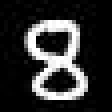

In [4]:
digits_image_dictionary[8][ :, :, 10] # how does the indexing work? This is the 10th example of the digit "8"

Next, let's partition the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` into training and testing datasets. We randomly select `number_of_training_examples::Int` images per digit for training, and the remaining images are used for testing. In each case, we convert the $28\times 28$ images into vector format by linearizing the matrix into a vector of 784 pixels.

Let's start with the training dataset. 

> __What is vectorization?__ Each $N\times N$ image array containing grayscale values at each pixel is converted to an $N^{2}$ vector by concatenating pixel values. The image class (the digit it represents) is converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). 

Let's save the training data in the `training_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable.


In [5]:
training_image_dataset = let

    # initialize - empty collection to hold (image vector, one-hot label) tuples
    training_image_dataset = Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}();

    # build training tuples - iterate over each digit class (0, 1, ..., 9)
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # encode digit i as a one-hot vector over 0–9
        X = digits_image_dictionary[i]; # grab the 28×28×n array of all images for digit i

        for t ∈ 1:number_of_training_examples
            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec; # flatten the 28×28 image matrix into a 784-element vector
            push!(training_image_dataset, (D, Y)); # store the (image vector, label) pair
        end
    end

    # return -
    training_image_dataset
end

25000-element Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}:
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03137254901960784, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00784313725490196, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411764705882  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00784313725490196  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01568627450980392  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 

Next, we load `number_of_test_examples::Int` images from the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` for testing purposes. We save the test data in the `testing_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable.


In [6]:
testing_image_dataset = let
    
    # initialize - empty collection to hold (image vector, one-hot label) tuples
    testing_image_dataset = Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}()
    
    # build testing tuples - use images *after* the training partition for each digit
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # encode digit i as a one-hot vector over 0–9
        X = digits_image_dictionary[i]; # grab the 28×28×n array of all images for digit i
        
        for t ∈ (number_of_training_examples+1):number_of_examples
            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec; # flatten the 28×28 image matrix into a 784-element vector
            push!(testing_image_dataset, (D, Y)); # store the (image vector, label) pair
        end
    end

    # return -
    testing_image_dataset
end;

### Implementation
Before constructing the OvR datasets, we define three helper functions that will be used across all tasks:

> __Helper functions:__
>
> * `downsample_image(x::Vector{Float64}, pool::Int)::Vector{Float64}` reduces a 784-pixel image vector to a smaller feature vector by average pooling over non-overlapping $\text{pool}\times\text{pool}$ blocks.
> * `build_ovr_dataset(...)` takes the full image dataset and a target digit, then constructs a balanced binary dataset with $\pm 1$ labels and downsampled features.
> * `ovr_confusion_for_digit(digit::Int; ...)` evaluates a trained OvR classifier on test data and returns the confusion matrix, accuracy, predictions, true labels, and class probabilities.

Let's define these functions:

In [7]:
"""
    downsample_image(x::Vector{Float64}, pool::Int)::Vector{Float64}

Reduce a 784-pixel image vector to a smaller feature vector by average pooling 
over non-overlapping pool×pool blocks. For pool = 4, a 28×28 image becomes 7×7 = 49 features.
"""
function downsample_image(x::Vector{Float64}, pool::Int)::Vector{Float64}

    # reshape - convert the 784-element vector back into a 28×28 image matrix
    # note: we transpose because the original vectorization used column-major order
    img = reshape(x, (number_of_cols, number_of_rows))';
    new_rows = number_of_rows ÷ pool; # number of rows in the downsampled image (28÷4 = 7)
    new_cols = number_of_cols ÷ pool; # number of cols in the downsampled image (28÷4 = 7)

    # average pooling - replace each pool×pool block with its mean value
    pooled = zeros(Float64, new_rows, new_cols);
    for i ∈ 1:new_rows
        for j ∈ 1:new_cols
            r = (pool*(i-1)+1):(pool*i); # row range for this block
            c = (pool*(j-1)+1):(pool*j); # col range for this block
            pooled[i,j] = mean(img[r,c]); # average all pixel values in this block
        end
    end

    # return - flatten the pooled matrix back into a vector
    return vec(pooled);
end;

"""
    build_ovr_dataset(image_dataset, digit; number_positive, number_negative, pool)

Build a balanced binary dataset for one-vs-rest classification. 
Returns (X, y) where X is the downsampled feature matrix and y ∈ {+1, -1}.
"""
function build_ovr_dataset(image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}},
    digit::Int; number_positive::Int = 200, number_negative::Int = 200, pool::Int = 4)

    # collect indices for positive and negative classes -
    # positive = images that ARE the target digit, negative = everything else
    pos_idx = Int[];
    neg_idx = Int[];
    for (i, (x, y_onehot)) ∈ enumerate(image_dataset)
        label = number_digit_array[argmax(y_onehot)]; # decode one-hot label to integer digit
        if (label == digit)
            push!(pos_idx, i); # this image matches the target digit
        else
            push!(neg_idx, i); # this image is some other digit
        end
    end

    # sample a balanced subset - randomly pick equal numbers of positive and negative examples
    pos_sel = pos_idx[randperm(length(pos_idx))[1:number_positive]]; # random sample of positive indices
    neg_sel = neg_idx[randperm(length(neg_idx))[1:number_negative]]; # random sample of negative indices
    selected = vcat(pos_sel, neg_sel); # combine positive and negative indices
    selected = selected[randperm(length(selected))]; # shuffle so positives and negatives are interleaved

    # allocate feature matrix and label vector -
    features_per_image = (number_of_rows ÷ pool) * (number_of_cols ÷ pool); # e.g., 7×7 = 49 for pool = 4
    X = Array{Float64,2}(undef, length(selected), features_per_image); # each row is one downsampled image
    y = Array{Int64,1}(undef, length(selected)); # binary label for each example
    for (k, idx) ∈ enumerate(selected)
        x, y_onehot = image_dataset[idx]; # grab the image vector and one-hot label
        X[k,:] = downsample_image(x, pool); # downsample and store as row k of the feature matrix
        label = number_digit_array[argmax(y_onehot)]; # decode one-hot to integer digit
        y[k] = (label == digit) ? 1 : -1; # +1 if this is the target digit, -1 otherwise
    end

    # return - feature matrix X and binary label vector y
    return X, y;
end;

"""
    ovr_confusion_for_digit(digit; dataset, models)

Evaluate the trained OvR classifier for a single digit on its test dataset.
Returns the confusion matrix, accuracy, predicted labels, true labels, and probability matrix.
"""
function ovr_confusion_for_digit(digit::Int;
    dataset::Dict = ovr_testing_dataset,
    models::Dict = ovr_model_dictionary)

    # check inputs - make sure we have data and a model for this digit
    @assert haskey(dataset, digit) "Digit $(digit) not found in test dataset."
    @assert haskey(models, digit) "Digit $(digit) not found in model dictionary."

    # setup - get the test data for this digit and augment with a bias column of ones
    X_test, y_test = dataset[digit]; # X_test is the feature matrix, y_test is the ±1 label vector
    number_of_examples = size(X_test, 1); # how many test examples?
    Xb = [X_test ones(number_of_examples)]; # append a column of ones to account for the bias term
    model = models[digit]; # retrieve the trained model for this digit

    # classify - compute class probabilities and convert to ±1 predicted labels
    P = classify(Xb, model); # P is n×2: col 1 = P(y=+1), col 2 = P(y=-1)
    ŷ = zeros(Int64, number_of_examples); # allocate predicted label vector
    for i ∈ 1:number_of_examples
        ŷ[i] = (P[i,1] ≥ P[i,2]) ? 1 : -1; # predict +1 if P(y=+1) ≥ P(y=-1), else -1
    end

    # compute confusion matrix and accuracy -
    CM = confusion(y_test, ŷ); # 2×2 confusion matrix: rows = true labels, cols = predicted labels
    accuracy = (CM[1,1] + CM[2,2]) / length(y_test); # fraction of correct predictions (diagonal sum / total)

    # return -
    return CM, accuracy, ŷ, y_test, P
end;

___

## Task 1: Create the One versus the Rest (OvR) Dataset
In this task, we create one binary dataset per digit. For a chosen digit `k`, we set the label to `+1` when the image shows digit `k`, and to `-1` otherwise.

> __Implementation note__:
>
> The logistic regression learner in this package uses a finite-difference approximation of the gradient, which is expensive for 784-pixel inputs. We need to reduce the dimensionality of the input data to make training feasible within a reasonable time frame. 
> 
> __Workaround:__ To keep the workflow interactive, we first reduce each $28\times 28$ image to a compact feature vector and then build balanced positive/negative subsets for each digit. This preserves the OvR logic while keeping the optimization step manageable.

We store the results in two dictionaries: `ovr_training_dataset` and `ovr_testing_dataset`. Each dictionary maps a digit to a tuple `(X, y)` where `X` is the feature matrix and `y` is the $\pm 1$ label vector. These balanced datasets are the foundation for training individual classifiers in Task 2.


In [ ]:
ovr_training_dataset, ovr_testing_dataset = let

    # initialize - dictionaries mapping digit → (feature matrix, label vector) for train and test
    training_dict = Dict{Int, Tuple{Array{Float64,2}, Vector{Int64}}}();
    testing_dict = Dict{Int, Tuple{Array{Float64,2}, Vector{Int64}}}();

    # options -
    pool = 4; # average pooling factor: 28÷4 = 7, so each image becomes 7×7 = 49 features
    ovr_training_positive = 200; # number of positive examples (images of the target digit) for training
    ovr_training_negative = 200; # number of negative examples (images of all other digits) for training
    ovr_testing_positive = 100; # number of positive examples for testing
    ovr_testing_negative = 100; # number of negative examples for testing

    # TODO: Build a balanced OvR dataset for each digit.
    # Step 1: loop over digits in number_digit_array.
    # Step 2: call build_ovr_dataset(...) for both training_image_dataset and testing_image_dataset.
    # Step 3: store (Xtr, ytr) in training_dict[digit] and (Xte, yte) in testing_dict[digit].
    # Hint: use the pool, *_positive, and *_negative options above.

    #= SOLUTION (commented)
    for digit ∈ number_digit_array
        
        # training dataset for this digit: 200 positive + 200 negative = 400 examples
        Xtr, ytr = build_ovr_dataset(training_image_dataset, digit,
            number_positive = ovr_training_positive,
            number_negative = ovr_training_negative,
            pool = pool
        );

        # testing dataset for this digit: 100 positive + 100 negative = 200 examples
        Xte, yte = build_ovr_dataset(testing_image_dataset, digit,
            number_positive = ovr_testing_positive,
            number_negative = ovr_testing_negative,
            pool = pool
        );

        training_dict[digit] = (Xtr, ytr); # store training data for this digit
        testing_dict[digit] = (Xte, yte); # store testing data for this digit
    end
    =#

    # return -
    training_dict, testing_dict
end;


___


## Task 2: Train an OvR Logistic Regression Model for Each Digit
In this task, we train one binary logistic regression model per digit using the OvR datasets constructed in Task 1. For each digit, we fit a separate classifier that learns to recognize that digit versus all others. We keep the trained models in the `ovr_model_dictionary::Dict{Int, MyLogisticRegressionClassificationModel}` dictionary.

> __Training procedure:__ 
> 
> For each digit, we append a column of ones to the feature matrix $\mathbf{X}$ to form the augmented matrix $\mathbf{X}_{b}\in\mathbb{R}^{n\times (p+1)}$, where $p = 49$ is the number of downsampled features and the extra column captures the bias term. We then minimize the logistic loss function:
> $$\ell(\mathbf{x},y,\boldsymbol{\theta}) = \log\left(1+\exp\left(-2\cdot y\cdot T\cdot\left(\mathbf{x}^{\top}\boldsymbol{\theta}\right)\right)\right) + \lambda\|\boldsymbol{\theta}\|_{2}^{2}$$
> where $\boldsymbol{\theta}\in\mathbb{R}^{p+1}$ is the parameter vector, $T > 0$ is a scaling parameter controlling the steepness of the sigmoid, $\lambda\geq 0$ is the $L_{2}$ regularization strength, and $y\in\{-1,+1\}$ is the binary label. The parameters are estimated using gradient descent with a finite-difference gradient approximation.
>
> * __Notation note (Temperature parameter):__ In this implementation, $T$ functions as **inverse temperature** (denoted $\beta$ in the lecture), not physical temperature. The parameter $\beta$ is used elsewhere in the code, hence this naming choice. Like inverse temperature in the lecture, large $T$ increases sigmoid steepness (high confidence), while small $T$ flattens it (high uncertainty).
>
> * __Notation note (Loss functions):__ The loss function above uses lowercase $\ell$ to denote the **per-sample loss** for a single training example. In the lecture, uppercase $J$ denotes the **total loss** summed over all training examples: $J(\theta) = \sum_{i=1}^{n} \ell(\mathbf{x}_i, y_i, \boldsymbol{\theta})$. The gradient descent algorithm in the code minimizes the per-sample loss for each example during training, which is equivalent to minimizing the total loss.

For time-limited scenarios, you can train once and save the parameter vectors to disk for later use.

> __Offline training option:__
>
> We save only the learned parameter vectors `ovr_parameter_dictionary::Dict{Int, Vector{Float64}}` to disk (not the full model structs), [because `JLD2` cannot serialize anonymous functions](https://github.com/JuliaIO/JLD2.jl) such as the loss function closure. On reload, we reconstruct the model objects from the saved parameters.
> If you change the feature-reduction factor (`pool`) or the dataset sizes, you should retrain and re-save.

Let's train the models:

In [ ]:
ovr_model_dictionary = let

    # initialize -
    digits_to_train = number_digit_array; # train a binary classifier for each digit (0–9)
    models_file = joinpath(_PATH_TO_DATA, "ovr_logistic_parameters.jld2"); # path to saved parameter file
    use_pretrained = true; # if true, try to load saved parameters instead of retraining
    train_if_missing = true; # if pretrained file is missing, train from scratch

    # training hyperparameters - these control the gradient descent optimizer
    maxiter = 150;  # maximum number of gradient descent iterations per digit
    ϵ = 1e-3;       # convergence tolerance: stop when the loss changes by less than ϵ
    α = 0.05;       # learning rate: step size for each gradient descent update
    h = 1e-6;       # finite-difference step size used to approximate the gradient numerically
    T = 1.0;        # temperature parameter: controls the steepness of the sigmoid curve
    λ = 0.0;        # L₂ regularization strength: penalizes large parameter values (0 = no regularization)

    # loss function - logistic loss with optional L₂ regularization
    # arguments: x = feature vector, y = ±1 label, T = temperature, λ = regularization, θ = parameters
    loss_function = (x, y, T, λ, θ) -> log(1 + exp(-2*y*T*(dot(x, θ)))) + λ*norm(θ, 2)^2;

    # TODO: Implement the pretrained vs. training branches.
    # If use_pretrained && isfile(models_file): load saved parameters and rebuild model_dictionary.
    # Else if train_if_missing: train one model per digit, save parameters to disk, and return.
    # Else: throw an error.

    model_dictionary = Dict{Int, MyLogisticRegressionClassificationModel}();
    #= SOLUTION (commented)
    if (use_pretrained == true && isfile(models_file))
        
        # load pretrained parameter vectors from disk -
        # we saved only the β vectors (not full model structs) because JLD2 can't serialize closures
        @load models_file ovr_parameter_dictionary

        # reconstruct model objects from saved parameters -
        # we rebuild each model using the saved β vector and the same hyperparameters/loss defined above
        model_dictionary = Dict{Int, MyLogisticRegressionClassificationModel}();
        for digit ∈ digits_to_train
            model_dictionary[digit] = build(MyLogisticRegressionClassificationModel, (
                parameters = ovr_parameter_dictionary[digit], # learned parameter vector for this digit
                learning_rate = α,
                ϵ = ϵ,
                h = h,
                λ = λ,
                T = T,
                loss_function = loss_function
            ));
        end

        # return -
        model_dictionary
    elseif (train_if_missing == true)

        # train one binary classifier per digit -
        model_dictionary = Dict{Int, MyLogisticRegressionClassificationModel}();
        for digit ∈ digits_to_train
            
            # build augmented feature matrix with bias column -
            # Xb = [X | 1] so the last element of θ acts as the bias (intercept) term
            X, y = ovr_training_dataset[digit]; # get the balanced training data for this digit
            number_of_examples = size(X, 1); # how many training examples?
            Xb = [X ones(number_of_examples)]; # append a column of ones for the bias term
            number_of_features = size(Xb, 2); # total features including the bias column (49 + 1 = 50)

            # build model - create an untrained model with small random initial parameters
            model = build(MyLogisticRegressionClassificationModel, (
                parameters = 0.01*ones(number_of_features), # initialize all parameters to 0.01
                learning_rate = α,
                ϵ = ϵ,
                h = h,
                λ = λ,
                T = T,
                loss_function = loss_function
            ));

            # learn parameters - run gradient descent to minimize the logistic loss on this digit's data
            trained = learn(Xb, y, model, maxiter = maxiter, verbose = true);
            model_dictionary[digit] = trained; # store the trained model for this digit
        end

        # save only parameter vectors to disk (JLD2 cannot serialize closures) -
        # extract the learned β vector from each trained model and save as a plain Dict{Int, Vector{Float64}}
        mkpath(_PATH_TO_DATA); # create the data directory if it doesn't exist
        ovr_parameter_dictionary = Dict{Int, Vector{Float64}}(); # dictionary to hold β vectors
        for (digit, model) ∈ model_dictionary
            ovr_parameter_dictionary[digit] = model.β; # extract the learned parameter vector
        end
        @save models_file ovr_parameter_dictionary # write the parameter dictionary to a JLD2 file

        # return -
        model_dictionary
    else
        error("No pretrained models found at $(models_file). Set `use_pretrained = false` to train.");
    end
    =#


    # return -
    model_dictionary
end;


___


## Task 3: Evaluate One Digit vs. Rest Using a Confusion Matrix
In this task, we validate the trained classifiers from Task 2 by selecting a digit and evaluating its OvR classifier on the test dataset. We compute predicted labels from the probability matrix and construct a confusion matrix to assess performance.

> __Reminder__: In this OvR setting, the __positive__ class means _is the digit_, and the __negative__ class means _is not the digit_.

Now let's select a digit and evaluate its classifier:

In [ ]:
digit_to_test = 8; # select which digit classifier to evaluate (change this to test a different digit)

# TODO: Evaluate the OvR classifier for this digit and unpack outputs.
# CM_ovr, accuracy_ovr, ŷ_ovr, y_ovr, P_ovr = ovr_confusion_for_digit(digit_to_test);


# initialize -
CM_ovr = nothing; # confusion matrix for the selected digit
accuracy_ovr = nothing; # overall accuracy for the selected digit
ŷ_ovr = nothing; # predicted labels (+1/-1)
y_ovr = nothing; # true labels (+1/-1)
P_ovr = nothing; # class probability matrix

#= SOLUTION (commented)
CM_ovr, accuracy_ovr, ŷ_ovr, y_ovr, P_ovr = ovr_confusion_for_digit(digit_to_test); # evaluate the OvR classifier for this digit
=#



The `ovr_confusion_for_digit` function returns the confusion matrix `CM_ovr::Matrix{Int64}`, the overall accuracy `accuracy_ovr::Float64`, the predicted labels `ŷ_ovr::Vector{Int64}`, the true labels `y_ovr::Vector{Int64}`, and the probability matrix `P_ovr::Matrix{Float64}`. Let's recompute and display the confusion matrix for the selected digit.

> __Error analysis__
>
> Total mistakes (or mistake percentage) is only part of the story. We should understand whether we are biased toward false positives or false negatives. How many times did we predict an image was the target digit when it was not (false positive)? How many times did we predict "not the digit" when it actually was (false negative)? For this we use a confusion matrix. 
>
> The confusion matrix for a binary classifier is typically structured as:
>
>|                     | **Predicted Positive** | **Predicted Negative** |
>|---------------------|------------------------|------------------------|
>| **Actual Positive** | True Positive (TP)     | False Negative (FN)    |
>| **Actual Negative** | False Positive (FP)    | True Negative (TN)     |
> 
> From the confusion matrix, we derive three key metrics:
>
> * __Accuracy__ is the fraction of correct predictions overall: $\texttt{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$. It tells us the overall success rate but can be misleading if classes are imbalanced, i.e., a classifier that predicts __negative__ for everything might achieve high accuracy on an imbalanced dataset.
>
> * __Precision__ answers: "When we predict positive, how often are we right?" $\texttt{precision} = \frac{TP}{TP + FP}$. High precision means fewer false alarms — if the classifier says an image is the target digit, it probably is.
>
> * __Recall__ (also called sensitivity) answers: "Of all the true positives, how many did we catch?" $\texttt{recall} = \frac{TP}{TP + FN}$. High recall means we are not missing instances of the target digit. Depending on the application, recall may be more critical than precision because failing to detect the target class can be costlier than a false alarm.

We compute the __confusion matrix__ to get these counts. We use the [confusion(...) method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/binaryclassification)

In [ ]:
# TODO: Recompute 2×2 confusion matrix from true labels vs predicted labels.
# CM_ovr = confusion(y_ovr, ŷ_ovr)

# initialize -
CM_ovr = nothing; # allocate variable to hold confusion matrix

#= SOLUTION (commented)
CM_ovr = confusion(y_ovr, ŷ_ovr) # recompute 2×2 confusion matrix from true labels vs predicted labels
=#



Let's compute the accuracy, precision, and recall for our logistic regression classifier on the test dataset. We store these metrics in the `accuracy_logistic::Float64`, `precision_logistic::Float64`, and `recall_logistic::Float64` variables, respectively.

In [ ]:
accuracy_logistic, precision_logistic, recall_logistic = let

    # TODO: Compute accuracy, precision, and recall from CM_ovr.
    # Hint: TP = CM_ovr[1,1], TN = CM_ovr[2,2], FP = CM_ovr[2,1], FN = CM_ovr[1,2]

    # initialize -
    accuracy = nothing; # overall accuracy
    precision = nothing; # precision
    recall = nothing; # recall
    
    #= SOLUTION (commented)

    # extract confusion matrix values -
    TP = CM_ovr[1,1]; # true positives
    TN = CM_ovr[2,2]; # true negatives
    FP = CM_ovr[2,1]; # false positives
    FN = CM_ovr[1,2]; # false negatives

    # compute metrics -
    accuracy = (TP + TN) / (TP + TN + FP + FN); # accuracy
    precision = TP / (TP + FP); # precision
    recall = TP / (TP + FN); # recall

    # print so the user can see -
    println("Logistic Regression Accuracy: $(round(accuracy*100,digits=2))%")
    println("Logistic Regression Precision: $(round(precision*100,digits=2))%")
    println("Logistic Regression Recall: $(round(recall*100,digits=2))%")

    # return -
    accuracy, precision, recall
    =#


    # return -
    accuracy, precision, recall
end;


___


## Summary 
The OvR strategy decomposes multi-class classification into independent binary problems, enabling the direct application of binary logistic regression to multi-digit recognition.

> __Key Takeaways:__
>
> * __OvR reframes multiclass prediction as a set of binary judgments:__ This keeps the modeling simple while still supporting multi-digit recognition.
> * __Data preparation drives feasibility:__ Balancing classes and feature reduction make finite-difference optimization practical without changing the OvR logic.
> * __Evaluation is about behavior, not just a score:__ Confusion matrices expose which mistakes dominate, and accuracy/precision/recall make those tradeoffs explicit.

This simple, scalable approach provides a foundation for extending binary classifiers to multi-class settings.
___
